# Load Data

In [1]:
import geopandas as gpd
import pandas as pd
from datetime import datetime
import os 

directory = '/Users/arthurcalvi/Data/results/disturbances/matching_france_v04_EPSG3857.parquet'
#TO utm crs
gdf = gpd.read_parquet(directory).to_crs(epsg=32631)

In [2]:
gdf.drop_duplicates(subset=['index_SS', 'year'], inplace=True)
gdf.shape[0]

5870700

# Utils

In [3]:
import string
from unidecode import unidecode
from shapely geometry import shape

def str_wo_space(x):
    return  unidecode(x.translate(str.maketrans('', '', string.punctuation)).replace(' ', '-'))

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def localisation(geometry):
    centroid = shape(geometry).centroid 
    Latitude = str(centroid.y)
    Longitude = str(centroid.x)
    location = geolocator.reverse(Latitude+","+Longitude)
    dict_loc = location.raw['address']
    keys = [x for x in ['country_code', 'state', 'county', 'city'] if x in dict_loc.keys()]
    name = '-'.join([ str_wo_space(dict_loc[key]) for key in keys])
    return name, Latitude, Longitude

In [4]:
from shapely.geometry import Point
import random
random.seed()


def get_bounding_box(row, gdf):
    aoi = Point(row.geometry.centroid.x, row.geometry.centroid.y).buffer(4750, cap_style=3)
    neighbors = gdf.clip(aoi)
    neighbors = neighbors.append(row)

    return neighbors, aoi

def get_random_bounding_box(gdf, gdf_ref):
    random_row = random.choice(gdf_ref.index.tolist())
    row = gdf_ref.loc[[random_row]]
    return get_bounding_box(row, gdf)

def compute_IoU(bounds1, bounds2):
    if bounds1.intersects(bounds2):
        IoU = bounds1.intersection(bounds2).area / bounds1.union(bounds2).area
    else: 
        IoU = 0
        
    return IoU

# Load Chronos

In [5]:
%load_ext autoreload
%autoreload 2
from chronos import Chronos

chr = Chronos(delta_min=20, cc1=0, cc2=75, buffer=0, nodata=10, 
            alpha = 0.1, show_aoi=False, shadow=True, registration=True,
            pansharpening=True, sharpening=True, force_reproject=False, 
            normalization=None, verbose=2, n_jobs=8, prefer='threads')

/Users/arthurcalvi/Venv/Download/lib/python3.9/site-packages/rasterio/path.py:15: RasterioDeprecationWarning: rasterio.path will be removed in version 1.4.
  warnings.warn(


ConnectionError: HTTPSConnectionPool(host='prod-catalog.internal.kayrros.org', port=443): Max retries exceeded with url: /api/v2/collections/nasa-landsat-8-oli+tirs-c2-l2-t1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x165373130>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

# Test pipeline



In [6]:
#TODO change to UTM crs

from shapely.ops import unary_union
#load greco
file = '/Users/arthurcalvi/Data/eco-regions/France/ser_l93_new/ser_l93_new.shp'
greco = gpd.read_file(file)

greco['GRECO'] = greco['codeser'].apply(lambda x: x[0])

#group polygon by the column GRECO
greco = greco.dissolve(by='GRECO')
greco.reset_index(inplace=True)
#drop étang de berre
greco = greco[greco['GRECO'] != '-']
greco.geometry = greco.geometry.normalize()
greco.geometry = greco.geometry.apply(unary_union)
#to UTM
greco = greco.to_crs(epsg=32631)


In [11]:
from datetime import datetime, timedelta, timezone
from rasterio.warp import transform_geom
from shapely.geometry import shape 
import shutil 
from collections import defaultdict
import itertools

#import tqdm notebook
from tqdm.notebook import tqdm

#avoid FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


n = 1000
n_class = gdf['class'].unique().shape[0]
n_region = greco['GRECO'].unique().shape[0]
N = int(n / (n_class * n_region))
print('Nbr of aoi to download per class and per region:', N)

dir_ = '/Users/arthurcalvi/Data/disturbances-ex/france_tiny_tuile'
count_download = 0
delta = timedelta(days=3*365)
first = True

#load set_aoi from pickle and add check for existing file set_aoi.pkl
import pickle
count = 0 
list_aoi = []
dict_aoi = dict()
if os.path.isfile(os.path.join(dir_, 'set_aoi.pkl')):
    with open('dict_aoi.pkl', 'rb') as f:
        dict_aoi = pickle.load(f)
    for key in dict_aoi.keys():
        list_aoi.extend(list(itertools.chain.from_iterable(dict_aoi[key].values())))

    

for region in greco['GRECO'].unique():
    #simplify geometry
    geometry = greco[greco['GRECO'] == region].geometry.iloc[0].buffer(7000).simplify(7000)
    gdf_region = gdf.clip(geometry)

    for cause in tqdm(gdf_region['class'].unique()):
        
        #initailize dict_aoi for region and cause if no key
        dict_aoi.setdefault(region, dict())
        dict_aoi[region].setdefault(cause, [])

        if len(dict_aoi[region][cause]) >= N:
            pass 
        else :
            gdf_class = gdf_region[gdf_region['class'] == cause]
            if gdf_class.shape[0] > 0:
                count += 1 
                for i in range(N):
                    max_IoU = 1.
                    if len(list_aoi) == 0:
                        gdf_neighbors, current_aoi = get_random_bounding_box(gdf_region, gdf_class)
                        max_IoU = 0
                    else:
                        j = 0
                        while max_IoU > 0.01 and j<100:
                            j += 1
                            #get random bounding box
                            try :
                                gdf_neighbors, current_aoi = get_random_bounding_box(gdf_region, gdf_class)
                            except:
                                print('j:', j)
                                break

                            #compute IoUs
                            max_IoU = max([compute_IoU(current_aoi, aoi) for aoi in list_aoi])
                    
                    if max_IoU > 0.01:
                        pass
                    else:
                        #delete row in gdf and gdf_class that are in neighbors
                        gdf_class = gdf_class[~gdf_class.index.isin(gdf_neighbors.index)]
                        gdf_region = gdf_region[~gdf_region.index.isin(gdf_neighbors.index)]
                        gdf = gdf[~gdf.index.isin(gdf_neighbors.index)]

                        #adding new aoi to set
                        dict_aoi[region][cause].append(current_aoi)

                        #dicted aoi is a dict of defaultdict(list), so we need to flatten it into a list
                        for key in dict_aoi.keys():
                            list_aoi.extend(list(itertools.chain.from_iterable(dict_aoi[key].values())))

            # list_aoi = list(itertools.chain.from_iterable(dict_aoi[region].values()))
            

            # #downlaod data
            # download = True
            # start_date = datetime(gdf_neighbors.year.min(), 1, 1, 10, 10, 10, tzinfo=timezone.utc) - delta
            # end_date = datetime(gdf_neighbors.year.max(), 12, 31, 10, 10, 10, tzinfo=timezone.utc) + delta

            # geometry = transform_geom('epsg:3857', 'epsg:4326', current_aoi.convex_hull)
            # current_aoi = gpd.GeoDataFrame({'geometry': [current_aoi]}, crs='epsg:3857').geometry.iloc[0]

            # #loc
            # name, Latitude, Longitude = localisation(geometry)

            # name_folder = '_'.join([start_date.strftime('%Y%m%d'), end_date.strftime('%Y%m%d'), name, f'Lat{float(Latitude) :.2f}', f'Lon{float(Longitude) :.2f}', str(cause)])
            # folder = os.path.join(dir_, name_folder)

            # #read if there is a log.txt
            # if os.path.isfile(os.path.join(folder, 'download.txt')):
            #     with open(os.path.join(folder, 'download.txt'), 'r') as f:
            #         log = f.read()

            #     #if there is a log.txt and it is OK, pass
            #     if log == 'Download: OK':
            #         download = False
            #         count_download += 1

            # if download :
            #     if first:
            #         print('Nbr of already downloaded aoi:', count_download)

            #     # try :
            #     print('downloading at:', folder)
            #     results = chr.download(folder, current_aoi, start_date, end_date, \
            #             indices=['rgb', 'ndvi', 'evi', 'crswir', 'nbr', 'qa', 'cloud_mask']) 
            #     log = 'Download: OK'
            #     #write log inside folder
            #     with open(os.path.join(folder, 'download.txt'), 'w') as f:
            #         f.write(log)


                # #write gdf_neighbors in parquet file
                # gdf_neighbors.to_parquet(os.path.join(folder, 'disturbance.parquet'))


                # # except : 
                # #     shutil.rmtree(folder)
                # first = False
        
# save set_aoi in pickle
with open(os.path.join(dir_, 'set_aoi.pkl'), 'wb') as f:
    pickle.dump(dict_aoi, f)

Nbr of aoi to download per class and per region: 15


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

j: 1
j: 1
j: 1
j: 1
j: 1
j: 1
j: 1
j: 1
j: 1
j: 1


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
# save set_aoi in pickle
with open(os.path.join(dir_, 'set_aoi.pkl'), 'wb') as f:
    pickle.dump(dict_aoi, f)

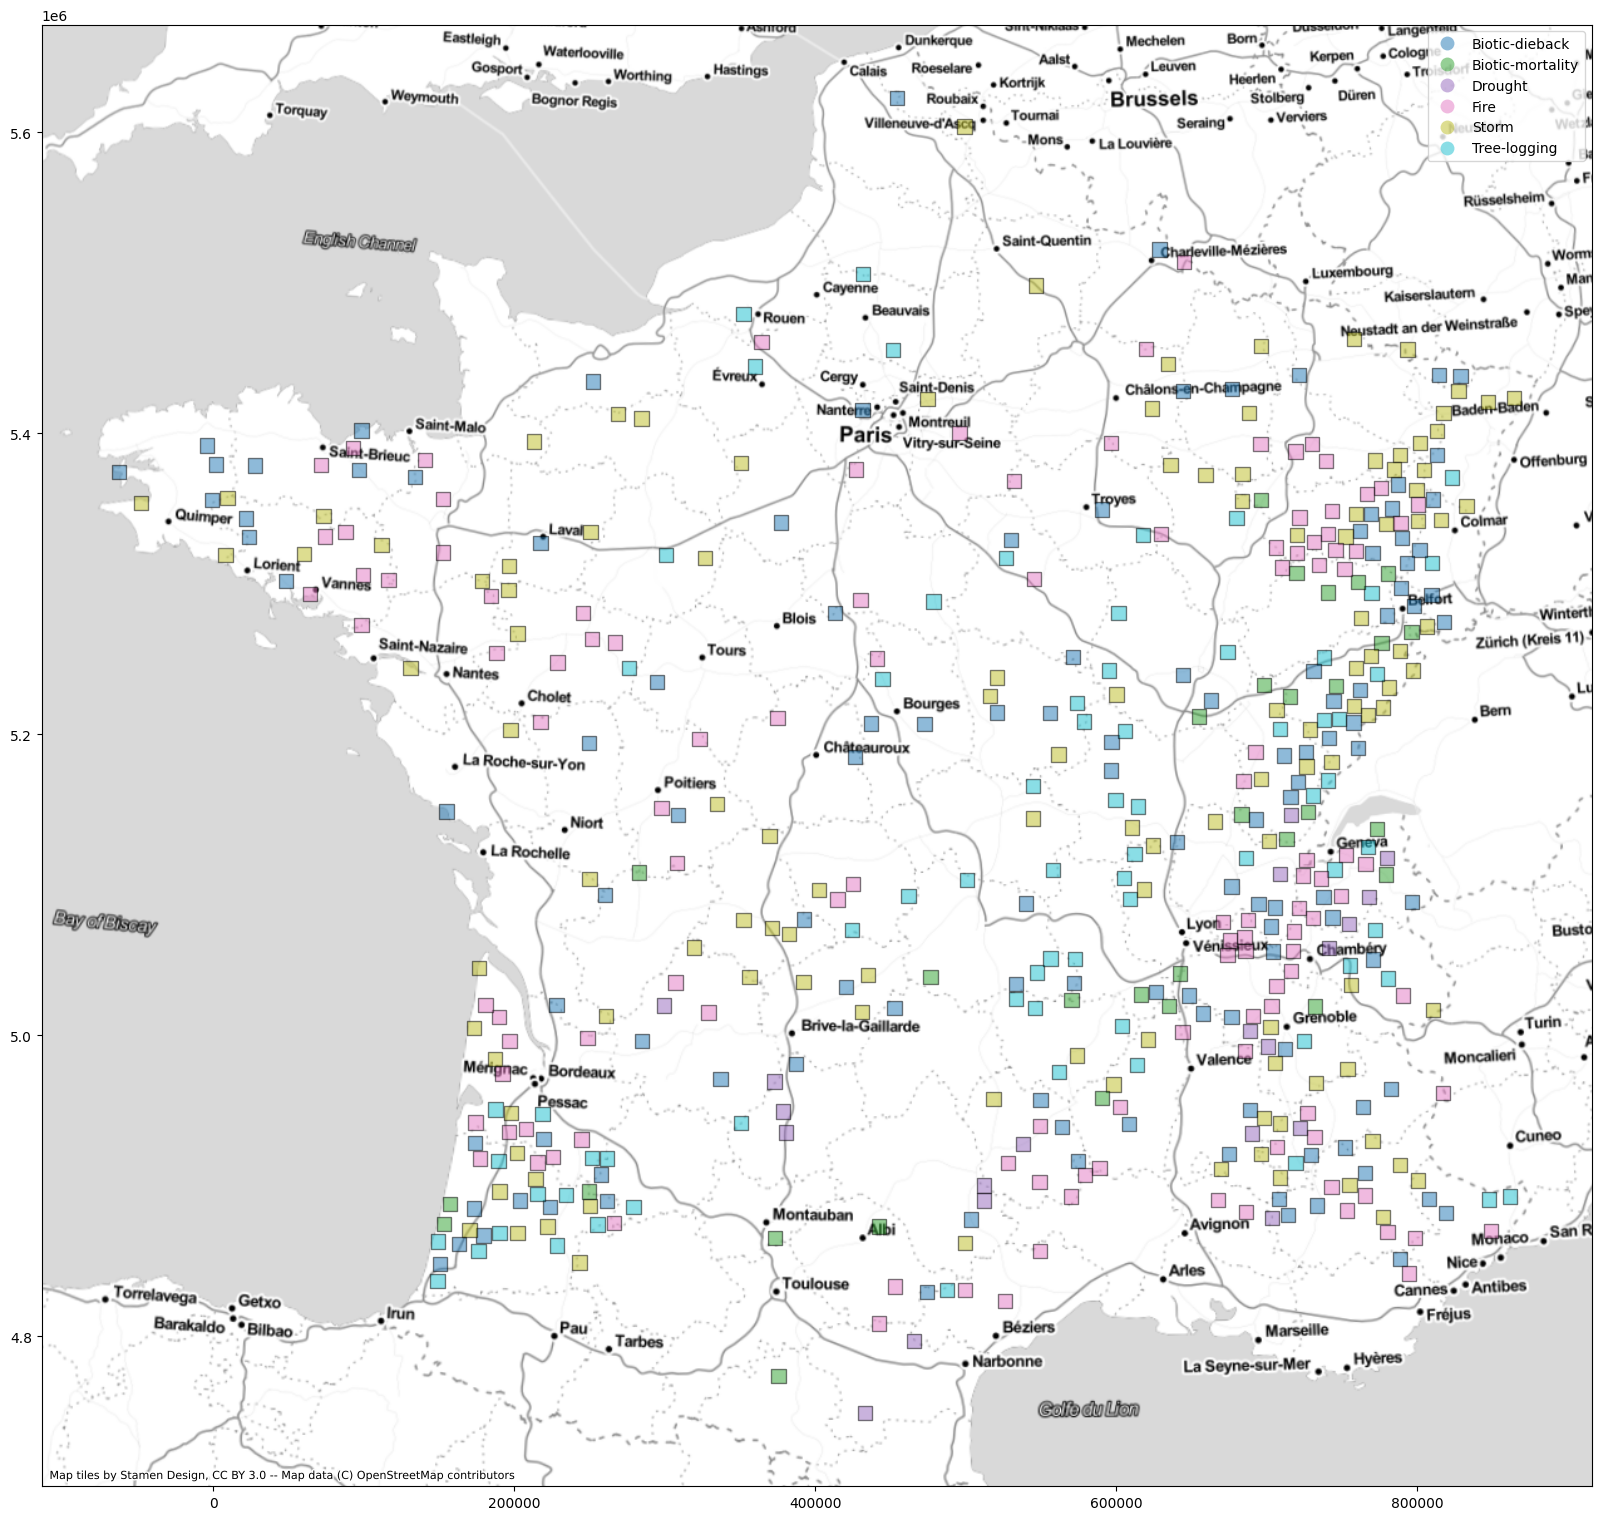

In [16]:
#construt GDF from set_aoi
lgdf = []
for region in dict_aoi.keys():
    for cause in dict_aoi[region].keys():
        gdf_aoi = gpd.GeoDataFrame({'geometry': dict_aoi[region][cause]}, crs='epsg:32631')
        gdf_aoi['region'] = region
        gdf_aoi['cause'] = cause
        lgdf.append(gdf_aoi)

gdf_aoi = pd.concat(lgdf)
#to GeoDataFrame
gdf_aoi = gpd.GeoDataFrame(gdf_aoi, geometry='geometry', crs='epsg:32631')


#plot gdf_aoi with basemap from contextily
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 20)

ax = gdf_aoi.plot(alpha=0.5, edgecolor='k', column='cause', legend=True)
ctx.add_basemap(ax, crs=gdf_aoi.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
plt.show()


In [24]:
# from datetime import datetime, timedelta, timezone
# from rasterio.warp import transform_geom
# from shapely.geometry import shape 
# import shutil 
# from collections import defaultdict
# import itertools

# #import tqdm notebook
# from tqdm.notebook import tqdm

# #avoid FutureWarning
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# n = 1000
# n_class = gdf['class'].unique().shape[0]
# N = int(n / n_class)
# print('Nbr of aoi to download per class:', N)

# dir_ = '/Users/arthurcalvi/Data/disturbances-ex/france_tiny_tuile'
# count_download = 0
# delta = timedelta(days=3*365)
# first = True

# #load set_aoi from pickle and add check for existing file set_aoi.pkl
# import pickle
# if os.path.isfile(os.path.join(dir_, 'set_aoi.pkl')):
#     with open('dict_aoi.pkl', 'rb') as f:
#         dict_aoi = pickle.load(f)
#     list_aoi = list(itertools.chain.from_iterable(dict_aoi.values()))
# else :
#     dict_aoi = defaultdict(list)
#     list_aoi = []

# for cause in gdf['class'].unique():

#     if len(dict_aoi[cause]) >= N:
#         pass 
#     else :
#         gdf_class = gdf[gdf['class'] == cause]

#         for i in tqdm(range(N)):
#             max_IoU = 1.
#             if len(list_aoi) == 0:
#                 gdf_neighbors, current_aoi = get_random_bounding_box(gdf_region, gdf_class)
#             else:
#                 j = 0
#                 while max_IoU > 0.0 and j<100:
#                     j += 1
#                     #get random bounding box
#                     gdf_neighbors, current_aoi = get_random_bounding_box(gdf_region, gdf_class)

#                     #compute IoUs
#                     max_IoU = max([compute_IoU(current_aoi, aoi) for aoi in list_aoi])

#             #delete row in gdf and gdf_class that are in neighbors
#             gdf_class = gdf_class[~gdf_class.index.isin(gdf_neighbors.index)]
#             gdf = gdf[~gdf.index.isin(gdf_neighbors.index)]

#             #adding new aoi to set
#             dict_aoi[cause].append(current_aoi)
#             list_aoi = list(itertools.chain.from_iterable(dict_aoi.values()))
            

#             # #downlaod data
#             # download = True
#             # start_date = datetime(gdf_neighbors.year.min(), 1, 1, 10, 10, 10, tzinfo=timezone.utc) - delta
#             # end_date = datetime(gdf_neighbors.year.max(), 12, 31, 10, 10, 10, tzinfo=timezone.utc) + delta

#             # geometry = transform_geom('epsg:3857', 'epsg:4326', current_aoi.convex_hull)
#             # current_aoi = gpd.GeoDataFrame({'geometry': [current_aoi]}, crs='epsg:3857').geometry.iloc[0]

#             # #loc
#             # name, Latitude, Longitude = localisation(geometry)

#             # name_folder = '_'.join([start_date.strftime('%Y%m%d'), end_date.strftime('%Y%m%d'), name, f'Lat{float(Latitude) :.2f}', f'Lon{float(Longitude) :.2f}', str(cause)])
#             # folder = os.path.join(dir_, name_folder)

#             # #read if there is a log.txt
#             # if os.path.isfile(os.path.join(folder, 'download.txt')):
#             #     with open(os.path.join(folder, 'download.txt'), 'r') as f:
#             #         log = f.read()

#             #     #if there is a log.txt and it is OK, pass
#             #     if log == 'Download: OK':
#             #         download = False
#             #         count_download += 1

#             # if download :
#             #     if first:
#             #         print('Nbr of already downloaded aoi:', count_download)

#             #     # try :
#             #     print('downloading at:', folder)
#             #     results = chr.download(folder, current_aoi, start_date, end_date, \
#             #             indices=['rgb', 'ndvi', 'evi', 'crswir', 'nbr', 'qa', 'cloud_mask']) 
#             #     log = 'Download: OK'
#             #     #write log inside folder
#             #     with open(os.path.join(folder, 'download.txt'), 'w') as f:
#             #         f.write(log)


#                 # #write gdf_neighbors in parquet file
#                 # gdf_neighbors.to_parquet(os.path.join(folder, 'disturbance.parquet'))


#                 # # except : 
#                 # #     shutil.rmtree(folder)
#                 # first = False
        
# #save set_aoi in pickle
# with open('set_aoi.pkl', 'wb') as f:
#     pickle.dump(dict_aoi, f)

Nbr of aoi to download per class: 166


  0%|          | 0/166 [00:00<?, ?it/s]

KeyboardInterrupt: 